# 🏠 PDF-Only RAG Demo 
**File:** `house.pdf`  &nbsp;|&nbsp; **Goal:** Answers come **only** from the house report PDF. If evidence is insufficient, reply with “I can not answer” / “Kan ikke svare basert på rapporten.”

---

## What is RAG? / Hva er RAG?
**EN** — Retrieval-Augmented Generation (RAG) combines **retrieval** (finding relevant passages) with **generation** (LLM answers).  
**NO** — RAG kombinerer **oppslag** (hente relevante utdrag) med **generering** (LLM-svar).

**Flow / Flyt**  
1. **Indexing / Indeksering** — Split `house.pdf` into chunks and build a searchable index (here: TF‑IDF).  
2. **Retrieval / Oppslag** — For a query, fetch Top‑k most similar chunks.  
3. **Generation / Generering** — Feed *Query + Retrieved Context* to the model (local LLaMA via Ollama). The model must answer **only** using context.  
4. **Guardrails / Sikring** — If similarity is too low, we respond with a refusal message.

> A built‑in **extractive** fallback summarizes retrieved chunks if generation is disabled.


## 0. Setup / Oppsett
- **Ollama (local LLaMA)**: install and ensure `http://localhost:11434` is running, e.g. `ollama run llama3.1`.  
- Dependencies: `scikit-learn`, `pypdf`, `requests`, `ipywidgets` (optional).

> Install only if needed / Installer kun hvis nødvendig:


In [1]:
# !pip install scikit-learn pypdf requests ipywidgets
# !pip install pypdf

## 1. Parameters / Parametere
- `PDF_PATH`: uses `house.pdf` in the same folder.  
- `GEN_BACKEND`: `"ollama"` to use local LLaMA via Ollama; `"none"` for extractive fallback.  
- `OLLAMA_MODEL`: e.g. `"llama3.1"`, `"llama3.2"`, `"qwen2.5"`, `"mistral"`.  
- `TOP_K`: number of retrieved chunks.  
- `THRESHOLD`: Top‑1 cosine similarity threshold for refusal.  
- **GPU**: simple toggles to *encourage* GPU usage (Ollama usually auto-detects GPU).

**Note / Merk:** Ollama typically uses GPU automatically if available. We expose `USE_GPU` and `GPU_NUM` to set common env vars and pass an `options` field to the API. Some settings may be ignored depending on model/build.


In [2]:
from dataclasses import dataclass
from typing import List, Tuple, Dict
import os

# === Files ===
PDF_PATH = "house.pdf"            # Ensure the file exists next to this notebook
assert os.path.exists(PDF_PATH), f"Missing {PDF_PATH}. Place your house report PDF beside this notebook."

# === Generation backend ===
GEN_BACKEND = "ollama"            # "ollama" (local LLaMA) or "none" (extractive)

# === Model ===
OLLAMA_MODEL = "mistral"       # Make sure you've pulled this model (e.g., `ollama pull llama3.1`)
OLLAMA_HOST = "http://127.0.0.1:11434"

# === Retrieval ===
TOP_K = 5                         # how many chunks to retrieve
THRESHOLD = 0.135                  # refusal if top-1 cosine < threshold (tune 0.05~0.30)

# === GPU controls (best-effort) ===
USE_GPU = True                    # set False to prefer CPU / disable GPU hints
GPU_NUM = 1                       # number of GPUs to request (if supported)
CUDA_VISIBLE_DEVICES = "0"        # which GPU IDs to expose

# --- Single-number GPU switch (0=CPU, >=1 = request that many GPUs) ---
GPU = 1
if isinstance(GPU, int):
    USE_GPU = GPU > 0
    if GPU > 0:
        GPU_NUM = GPU


# Apply best-effort environment hints
if USE_GPU:
    os.environ.setdefault("CUDA_VISIBLE_DEVICES", CUDA_VISIBLE_DEVICES)
    # Ollama generally auto-detects GPU; these are hints and may be ignored.
    os.environ.setdefault("OLLAMA_NUM_GPU", str(GPU_NUM))   # may or may not be used
    if "OLLAMA_NO_GPU" in os.environ:
        del os.environ["OLLAMA_NO_GPU"]
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    os.environ["OLLAMA_NO_GPU"] = "1"

print(f"PDF: {PDF_PATH}\nBackend: {GEN_BACKEND} / Model: {OLLAMA_MODEL}\nGPU: {USE_GPU} (GPU_NUM={GPU_NUM}, CUDA_VISIBLE_DEVICES={os.environ.get('CUDA_VISIBLE_DEVICES')})")

PDF: house.pdf
Backend: ollama / Model: mistral
GPU: True (GPU_NUM=1, CUDA_VISIBLE_DEVICES=0)


## 2. Read PDF & Chunk / Les PDF & del opp
We extract text per page, clean it, and create overlapping fixed-size chunks.  
Vi henter tekst per side, renser den, og lager overlappende biter (chunks).

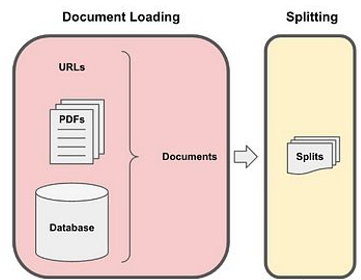

In [3]:
import re
from pypdf import PdfReader

def _clean_text(s: str) -> str:
    s = s.replace("\x00", " ")
    s = re.sub(r"[ \t]+", " ", s)
    s = re.sub(r"\s+\n", "\n", s)
    s = re.sub(r"\n{2,}", "\n\n", s)
    return s.strip()

def extract_pdf_text_with_pages(pdf_path: str) -> List[Tuple[int, str]]:
    reader = PdfReader(pdf_path)
    pages = []
    for i, page in enumerate(reader.pages, start=1):
        try:
            t = page.extract_text() or ""
        except Exception:
            t = ""
        pages.append((i, _clean_text(t)))
    return pages

def split_to_chunks(text: str, max_chars: int = 500, overlap: int = 80) -> List[str]:
    text = " ".join(text.split())
    chunks = []
    i = 0
    while i < len(text):
        chunk = text[i:i+max_chars]
        if chunk.strip():
            chunks.append(chunk)
        i += max_chars - overlap
    return chunks

pages = extract_pdf_text_with_pages(PDF_PATH)
total_chars = sum(len(p[1]) for p in pages)
print(f"Pages: {len(pages)}, total chars: {total_chars}")

Pages: 70, total chars: 98046


## 3. Build Index (TF‑IDF) / Bygg Indeks (TF‑IDF)
Cosine similarity over TF‑IDF vectors.  
Kosinuslikhet over TF‑IDF‑vektorer.


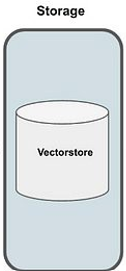

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

@dataclass
class Node:
    page: int
    chunk_id: int
    text: str

@dataclass
class Index:
    vectorizer: TfidfVectorizer
    matrix: any
    nodes: List[Node]

def build_index(pages: List[Tuple[int, str]], max_chars=500, overlap=80) -> Index:
    nodes: List[Node] = []
    for page_no, page_text in pages:
        if not page_text.strip():
            continue
        for cid, ch in enumerate(split_to_chunks(page_text, max_chars, overlap)):
            nodes.append(Node(page_no, cid, ch))
    if not nodes:
        raise ValueError("No extractable text. OCR the PDF first if it's a scanned image.")
    vec = TfidfVectorizer()
    X = vec.fit_transform([n.text for n in nodes])
    return Index(vec, X, nodes)

index = build_index(pages, max_chars=500, overlap=80)
feature_names = index.vectorizer.get_feature_names_out()
print(f"Indexed chunks: {len(index.nodes)}")
print(index.matrix)
print(feature_names[868])

Indexed chunks: 268
  (0, 868)	0.2077472615755605
  (0, 2474)	0.4384439769080549
  (0, 2756)	0.2353947076458676
  (0, 1127)	0.2104145499413234
  (0, 869)	0.2077472615755605
  (0, 1562)	0.21922198845402746
  (0, 967)	0.10467978185362985
  (0, 109)	0.13158165792973306
  (0, 3098)	0.21922198845402746
  (0, 1261)	0.16739770460598488
  (0, 3099)	0.14355187979303133
  (0, 2823)	0.12022809319455756
  (0, 2475)	0.415494523151121
  (0, 2502)	0.1524523694349464
  (0, 1389)	0.2077472615755605
  (0, 1649)	0.2353947076458676
  (0, 2308)	0.06426186696957005
  (0, 1795)	0.2353947076458676
  (0, 2965)	0.15777851383806887
  (0, 1815)	0.2353947076458676
  (1, 2474)	0.8365946147652665
  (1, 3099)	0.5478224626151755
  (2, 967)	0.1458968879875574
  (2, 109)	0.0916956171872538
  (2, 1333)	0.15276973894829426
  :	:
  (267, 3158)	0.115553239683635
  (267, 2223)	0.10579823740693567
  (267, 1031)	0.11993967680498142
  (267, 2281)	0.11993967680498142
  (267, 213)	0.12530824196033433
  (267, 2900)	0.1199396768049

## 4. Retrieve & Sufficiency / Oppslag & Tilstrekkelighet
If Top‑1 score < threshold → refuse.  
Hvis Top‑1‑score < terskel → avslag.


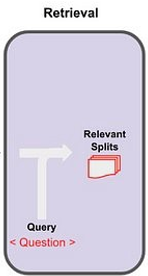

In [5]:
def retrieve(index: Index, query: str, k: int = TOP_K) -> List[Dict]:
    q = index.vectorizer.transform([query])
    sims = cosine_similarity(q, index.matrix)[0]
    order = sims.argsort()[::-1][:k]
    out: List[Dict] = []
    for rank, i in enumerate(order, start=1):
        n = index.nodes[i]
        out.append({
            "rank": rank,
            "score": float(sims[i]),
            "page": n.page,
            "chunk_id": n.chunk_id,
            "text": n.text
        })
    return out

def is_sufficient(contexts: List[Dict], threshold: float = THRESHOLD) -> bool:
    if not contexts:
        return False
    return contexts[0]["score"] >= threshold

# Quick peek / Rask sjekk
retrieve(index, "Any signs of mold or dampness? / Er det tegn til mugg eller fukt?", k=TOP_K)[:5]

[{'rank': 1,
  'score': 0.16640557986796423,
  'page': 20,
  'chunk_id': 2,
  'text': ' Tilgjengelighet Ikke relevant Oppsummering av sanitærutstyr TG-1 Type ventilering Mekanisk avtrekk Er ventilasjonen funksjonstestet? Ja Oppsummering av ventilasjon TG-1 Er det foretatt hulltaking fra tilstøtende rom? Ja Er det registrert fukt eller andre skader ved hulltaking? Nei Oppsummering av fukt TG-0 Fremlagt dokumentasjon Ja'},
 {'rank': 2,
  'score': 0.13560180337390745,
  'page': 25,
  'chunk_id': 2,
  'text': 'n eller andre bygninger på eiendommen? 0Ja 2Nei, ikke som jeg kjenner til 22 Har det vært mugg, sopp eller råte i sameiet eller borettslaget? 0Ja 2Nei, ikke som jeg kjenner til Planer og godkjenninger 23 Mangler boligen eller andre bygninger brukstillatelse eller ferdigattest for søknadspliktige tiltak? 0Ja 2Nei, ikke som jeg kjenner til 24 Har du bygd på eller gjort om kjeller, loft eller annet til boligrom? 0Ja 2Nei'},
 {'rank': 3,
  'score': 0.13157255891473135,
  'page': 11,
  'c

## 5. Generation (Ollama) + Extractive Fallback / Generering (Ollama) + Ekstraktiv reserve
We ask the model to **only** use the provided context; otherwise refuse.  
Vi ber modellen **kun** bruke konteksten; ellers avslå.


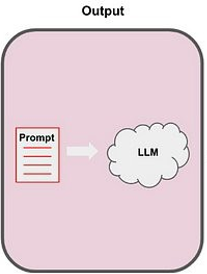

In [6]:
import requests

SYSTEM_MSG_EN = (
    "You are a careful assistant that must answer ONLY using the provided context. "
    "If the answer is not clearly supported, reply in English: 'I can not answer' and in Norwegian: 'Kan ikke svare basert på rapporten.'"
)
SYSTEM_MSG_NO = (
    "Du er en nøye assistent som bare skal svare ved å bruke gitt kontekst. "
    "Hvis svaret ikke er tydelig støttet, svar på Engelsk: 'I can not answer' og norsk: 'Kan ikke svare basert på rapporten.'"
)

USER_TPL_BI = """[EN] You are a house-report assistant. Answer strictly based on the retrieved context only.
- If evidence is insufficient, answer: 'I can not answer / Kan ikke svare basert på rapporten.'
- End with citations like (p.<page>#<chunk>).

[NO] Du er en husrapports-assistent. Svar strengt basert på konteksten under.
- Uten tilstrekkelig grunnlag: 'I can not answer / Kan ikke svare basert på rapporten.'
- Avslutt med henvisninger som (p.<side>#<chunk>).

Question / Spørsmål:
{question}

Context / Kontekst:
{context}
"""

def _format_context_block(ctxs: List[Dict]) -> str:
    lines = []
    for c in ctxs:
        lines.append(f"(Score={c['score']:.3f}) [p.{c['page']}#{c['chunk_id']}] {c['text']}")
    return "\n\n".join(lines)

def _ollama_generate(prompt: str, model: str = OLLAMA_MODEL, host: str = OLLAMA_HOST, temperature: float = 0.1, options: Dict = None) -> str:
    url = host.rstrip("/") + "/api/generate"
    payload = {
        "model": model,
        "prompt": f"<|system|>\n{SYSTEM_MSG_EN}\n{SYSTEM_MSG_NO}\n<|user|>\n{prompt}",
        "temperature": temperature,
        "stream": False
    }
    if options:
        payload["options"] = options
    r = requests.post(url, json=payload, timeout=120)
    r.raise_for_status()
    data = r.json()
    return data.get("response", "").strip()

# Prepare common Ollama options (best-effort; some builds ignore unknown keys)
OLLAMA_OPTIONS = {
    "temperature": 0.1,
    "num_ctx": 4096,
}
if USE_GPU:
    OLLAMA_OPTIONS["num_gpu"] = GPU_NUM  # may be ignored depending on backend

def generate_answer(question: str, contexts: List[Dict], backend: str = GEN_BACKEND) -> str:
    if not is_sufficient(contexts, THRESHOLD):
        return "I can not answer / Kan ikke svare basert på rapporten."

    context_block = _format_context_block(contexts)

    if backend == "ollama":
        try:
            prompt = USER_TPL_BI.format(question=question, context=context_block)
            ans = _ollama_generate(prompt, options=OLLAMA_OPTIONS)
            return ans if ans else "I can not answer / Kan ikke svare basert på rapporten."
        except Exception as e:
            bullets = "\n".join([f"- {c['text']} (p.{c['page']}#{c['chunk_id']})" for c in contexts[:3]])
            return f"(Generation failed; extractive fallback) Error: {e}\n\n" +                    " Extract the report as below / Nøkkelpunkter fra rapporten:\n" + bullets

    # Extractive fallback
    bullets = "\n".join([f"- {c['text']} (p.{c['page']}#{c['chunk_id']})" for c in contexts[:3]])
    return "Extract the report as below / Nøkkelpunkter fra rapporten:\n" + bullets

## 6. Ask Helper / Spørrehjelper
Use `ask("your question")` to run the full pipeline.  
Bruk `ask("spørsmålet ditt")` for å kjøre hele flyten.


In [7]:
def ask(question: str, k: int = TOP_K, show_context: bool = True) -> str:
    ctxs = retrieve(index, question, k=k)
    if show_context:
        print("=== Retrieved Chunks (by similarity) / Hentede biter ===")
        for c in ctxs:
            print(f"[{c['rank']}] score={c['score']:.3f} p.{c['page']}#{c['chunk_id']}")
            print(c["text"].strip()[:2000], "...\n")
    ans = generate_answer(question, ctxs, backend=GEN_BACKEND)
    print("=== Answer / Svar ===")
    return ans



In [23]:
ask("Hvor gammel er det huset?")

=== Retrieved Chunks (by similarity) / Hentede biter ===
[1] score=0.141 p.9#1
er fra 1959 og at bygningsdeler som ikke er skiftet kan være på slutten av sin levetid. Det er viktig å påpeke at bygningen anses å være oppført i henhold til de forskrifter som gjaldt da dette huset ble bygget, og det må derfor påregnes et avvik i forhold til dagens standard. 5. Arealinformasjon Arealmålingen er basert på Norsk standard 3940:2023 Areal- og volum-beregninger av bygninger. Arealet gjelder for tidspunktet da boligen ble målt. Rommene kan være måleverdige selv om bruken er i strid ...

[2] score=0.111 p.4#1
når delen er ny, men der dokumentasjon på faglig god utførelse mangler. TG-2 Tilstandsgrad 2: Bygningsdelen har vesentlige avvik Bygningsdelen skal enten ha feil utførelse, en skade eller symptomer på skade, sterk slitasje eller nedsatt funksjon. Graden gis når bygningsdelen trenger vedlikehold eller tiltak i nær fremtid. Graden skal også brukes når delen er gammel og det er grunn til å vars

'Huset ble bygget i 1959. (p.9#1)'

In [13]:
ask("Er det tegn til mugg eller fukt?")

=== Retrieved Chunks (by similarity) / Hentede biter ===
[1] score=0.228 p.20#2
Tilgjengelighet Ikke relevant Oppsummering av sanitærutstyr TG-1 Type ventilering Mekanisk avtrekk Er ventilasjonen funksjonstestet? Ja Oppsummering av ventilasjon TG-1 Er det foretatt hulltaking fra tilstøtende rom? Ja Er det registrert fukt eller andre skader ved hulltaking? Nei Oppsummering av fukt TG-0 Fremlagt dokumentasjon Ja ...

[2] score=0.186 p.25#2
n eller andre bygninger på eiendommen? 0Ja 2Nei, ikke som jeg kjenner til 22 Har det vært mugg, sopp eller råte i sameiet eller borettslaget? 0Ja 2Nei, ikke som jeg kjenner til Planer og godkjenninger 23 Mangler boligen eller andre bygninger brukstillatelse eller ferdigattest for søknadspliktige tiltak? 0Ja 2Nei, ikke som jeg kjenner til 24 Har du bygd på eller gjort om kjeller, loft eller annet til boligrom? 0Ja 2Nei ...

[3] score=0.180 p.11#1
normalt vedlikehold. 6.2 Vinduer og dører Ytterdør med slett overflate i B-30 og DB-30. Vinduer og balkongdø

'Nei, det er ingen tegn til mugg eller fukt i rapporten. (p.20#2) (p.25#2) (p.11#1) (p.15#2) (p.23#1)'

In [24]:
ask("Hvor gammel er Yu-Chung?")

=== Retrieved Chunks (by similarity) / Hentede biter ===
[1] score=0.130 p.4#1
når delen er ny, men der dokumentasjon på faglig god utførelse mangler. TG-2 Tilstandsgrad 2: Bygningsdelen har vesentlige avvik Bygningsdelen skal enten ha feil utførelse, en skade eller symptomer på skade, sterk slitasje eller nedsatt funksjon. Graden gis når bygningsdelen trenger vedlikehold eller tiltak i nær fremtid. Graden skal også brukes når delen er gammel og det er grunn til å varsle om faren for skader på grunn av alderen, eller når det er grunn til å overvåke delen spesielt på grunn ...

[2] score=0.096 p.15#1
ligheten, og kontrollen stopper ved veggjennomføringer. Resterende er borettslaget sitt ansvar. 6.9 Elektrisk Sikringsskap oppgradert i 2008. Deler av anlegget oppgradert på bad i 2017. Er det manglende vannstoppesystem i tilknytning til, eller manglende avrenning til sluk/avløp fra fordelerskap? Nei Har vannrør nådd en alder som gir økt risiko for skader eller følgeskader? Nei Er det mangl

'I can not answer / Kan ikke svare basert på rapporten.'

## 7. Demo Queries / Eksempelspørsmål
- Building age and recent repairs? / Byggeår og nylige reparasjoner?  
- Moisture/mold, leakage, or structural cracks? / Fukt/mugg, lekkasjer eller strukturelle sprekker?  
- Electrical/plumbing major issues? / Store feil i elektrisk anlegg eller røranlegg?  
- Any urgent risks noted? / Hasterisikoer nevnt?


## 8. Tuning & Improvements / Justering & Forbedringer
- **Chunks**: adjust `max_chars` & `overlap` in `build_index`.  
- **Threshold**: raise to be stricter; lower to recall more.  
- **Model**: swap `OLLAMA_MODEL` (e.g., `llama3.2:3b`, `qwen2.5`, `mistral`).  
- **Embeddings**: use sentence-transformers + FAISS for semantic retrieval (TF‑IDF kept minimal for teaching).  
- **Citations**: add post-check to enforce citation patterns or fall back to refusal.
